In [3]:
### Author: Gary Chen, Hojune Kim
### Date: June 15, 2023
### Last Updated: Jun 27, 2023
### Description: Inverse Radon Transform (sinogram/measurements -> image/obj)

import torch
import torch.fft
from torchvision.transforms.functional import rotate, InterpolationMode
import torch.nn.functional as F

import os
import math
import numpy as np
import matplotlib.pyplot as plt

# # Change this part to move to the correct directory
# !pwd
# new_directory = 'global/u1/h/hojunek/RadonTorch/'
# os.chdir(new_directory)

current_directory = os.getcwd()
print("Current directory:", current_directory)
files = os.listdir(current_directory)
print(files)

Current directory: /global/u1/h/hojunek/RadonTorch
['dataset_foam', 'forwardRadon', '.DS_Store', 'data', 'inverseRadon', '.git']


In [4]:
#####################
# helper function
#####################
def plot_1D_tensor(tensor):
    if isinstance(tensor, np.ndarray):
        # Plot the NumPy array directly
        tensor_array = tensor
    elif torch.is_tensor(tensor):
        # Move tensor to CPU if it resides on a CUDA device
        if tensor.is_cuda:
            tensor = tensor.cpu()

        # Convert tensor to a NumPy array
        tensor_array = tensor.numpy()
    else:
        raise ValueError("Unsupported input type. The input should be a PyTorch tensor or a NumPy array.")

    # Plot the tensor
    plt.plot(tensor_array)
    plt.title("1D Tensor Plot")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.show()

def plot_2_img_tensors(image1, image2, title1='img1', title2='img2'):
    # Convert complex-valued tensors to magnitude spectra
    if torch.is_complex(image1):
        image1 = torch.abs(image1)
    if torch.is_complex(image2):
        image2 = torch.abs(image2)

    # Convert tensors to CPU and numpy arrays
    image1_cpu = image1.detach().cpu().numpy()
    image2_cpu = image2.detach().cpu().numpy()

    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    plt.show()

def compare_2img_tensors(image1, image2, title1="img1", title2="img2"):
    image1_cpu = np.abs(image1.cpu().numpy())  # Take absolute value for complex tensor
    image2_cpu = np.abs(image2.cpu().numpy())  # Take absolute value for complex tensor
    difference_cpu = np.abs(image1.cpu() - image2.cpu()).numpy()  # Compute the absolute difference
    
    # Calculate average error
    average_error = np.sum(difference_cpu) / np.prod(difference_cpu.shape)
    
    # Plot the images
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1_cpu, cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2_cpu, cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(difference_cpu, cmap='gray')
    axs[2].set_title("Difference")
    plt.show()
    
    return average_error
    
class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor
data_loader = Data_loader()

def high_pass_filter(image, kernel_size):
    # Define the high-pass filter kernel
    kernel = torch.tensor([
        [-1, -1, -1],
        [-1,  8, -1],
        [-1, -1, -1]
    ]).unsqueeze(0).unsqueeze(0).float()  # Convert to 4D tensor

    # Move the filter kernel to the same device as the input tensor
    kernel = kernel.to(image.device)

    # Apply the convolution operation with the kernel
    filtered_image = F.conv2d(image, kernel, padding=kernel_size//2)

    # Remove the batch and channel dimensions
    filtered_image = filtered_image.squeeze()
    
    return filtered_image

def interp(x, xp, fp):
    m = (fp[1:] - fp[:-1]) / (xp[1:] - xp[:-1])
    b = fp[:-1] - (m * xp[:-1])

    indicies = torch.sum(torch.ge(x[:, None], xp[None, :]), 1) - 1
    indicies = torch.clamp(indicies, 0, len(m) - 1)

    return m[indicies] * x + b[indicies]

# check GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cuda


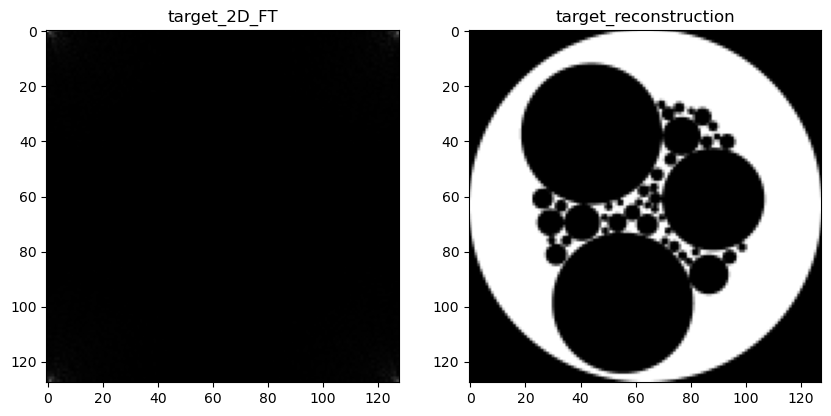

In [9]:
# Load data
sinogram_batch = data_loader.npy_to_tensor('./data/sinogram_batch_no_padding.npy')
object_batch = data_loader.npy_to_tensor('./dataset_foam/foam_training.npy')
sinogram1 = sinogram_batch[0,:,:]
object1 = object_batch[0,:,:]

target_2D_FT = torch.fft.fft2(object1)
target_reconstruction = torch.fft.ifft2(target_2D_FT)
plot_2_img_tensors(target_2D_FT,target_reconstruction,"target_2D_FT","target_reconstruction")

In [7]:
def iradon(radon_image, theta=None, output_size=None,
           filter="ramp", interpolation="linear", circle=True):

    device = radon_image.device  # Get the device of the input tensor
    if radon_image.ndim != 2:
        raise ValueError('The input image must be 2-D')
    
    if theta is None:
        n, m = radon_image.shape
        theta = torch.linspace(0, 179, n)
        th = (math.pi / 180.0) * theta
    else:
        theta = torch.tensor(theta, device=device)
        th = (math.pi / 180.0) * theta

    if len(theta) != radon_image.shape[0]:
        raise ValueError("The given ``theta`` does not match the number of "
                         "projections in ``radon_image``.")

    radon_image_temp = radon_image.unsqueeze(0).unsqueeze(0).to(device)  # Add batch and channel dimensions
    filtered_img = high_pass_filter(radon_image_temp, 3)
    # plot_1D_tensor(filtered_img[0])
    # plot_2_img_tensors(radon_image, filtered_img)

    radon_filtered = filtered_img[:radon_image.shape[0], :]
    reconstructed = torch.zeros((output_size, output_size)).to(device)
    
    # Determine the center of the projections (= center of sinogram)
    mid_index = radon_image.shape[1] // 2
    x = torch.arange(output_size).to(device)
    y = torch.arange(output_size).to(device)
    X, Y = torch.meshgrid(x, y)
    xpr = X - output_size // 2
    ypr = Y - output_size // 2

    # Reconstruct image by interpolation
    for i in range(len(theta)):
        # th is theta in radians
        x = ypr * torch.cos(th[i]) - xpr * torch.sin(th[i])
        xp = np.arange(radon_filtered.shape[1]) - mid_index
        fp = radon_filtered[i, :].cpu().numpy()
        backprojected = torch.tensor(np.interp(x.cpu().numpy(), xp, fp, left=0, right=0), device=device)
        reconstructed += backprojected
    
    return reconstructed


/global/common/software/nersc/pm-2022q4/sw/pytorch/1.13.1/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /mscratch/sd/s/swowner/pytorch-build/pytorch/1.13.1/pytorch/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


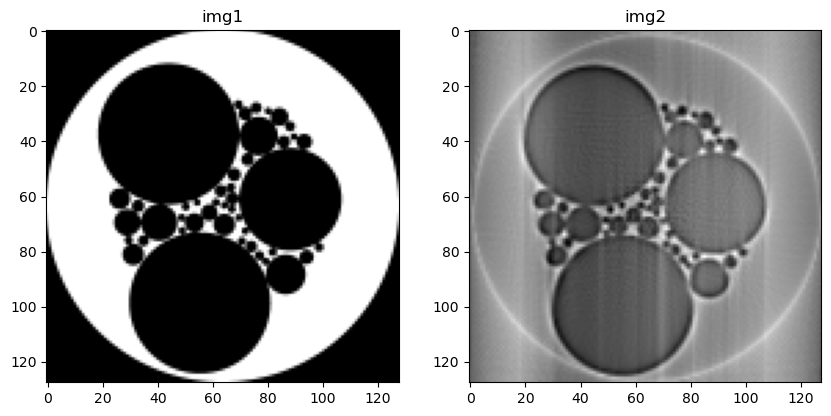

In [8]:
recon = iradon(sinogram1, theta=None, output_size=128)
plot_2_img_tensors(object1, recon)